Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from hmmlearn.hmm import GMMHMM
import os

Load data & Build Logreturn, Volatility

In [2]:
XIAOMI_CSV_PATH = r"E:/3.IS403/Đồ án/Dataset final/Xiaomi_clean.csv"  
df0 = pd.read_csv(XIAOMI_CSV_PATH)
df0.columns = [c.strip().replace(' ', '_') for c in df0.columns]
date_col = 'Date' if 'Date' in df0.columns else [c for c in df0.columns if 'date' in c.lower()][0]
df0[date_col] = pd.to_datetime(df0[date_col], errors='coerce')
df0 = df0.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)
close_candidates = ['Adj_Close','AdjClose','Close','close','Price','price']
close_col = None
for c in df0.columns:
    if c in close_candidates or c.lower() in ['close','adj close','adj_close','price']:
        close_col = c; break
if close_col is None:
    close_col = df0.select_dtypes(include=[np.number]).columns[0]
df = df0[[date_col, close_col]].rename(columns={date_col:'Date', close_col:'Close'}).copy()
df['LogReturn'] = np.log(df['Close']).diff()
df['Volatility'] = df['LogReturn'].rolling(20).std() * np.sqrt(252)
df = df.dropna(subset=['LogReturn','Volatility']).reset_index(drop=True)
df.head()

,Date,Close,LogReturn,Volatility
0,2018-08-06,17.219999,0.012858,0.770445
1,2018-08-07,17.420000,0.011548,0.624424
2,2018-08-08,17.139999,-0.016204,0.625578
3,2018-08-09,18.080000,0.053391,0.656578
4,2018-08-10,18.160000,0.004415,0.511656


Split

In [3]:
T = len(df)
n_train = int(0.6*T)
n_val   = int(0.2*T)
df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train+n_val].copy()
df_test  = df.iloc[n_train+n_val:].copy()

def X_from(d):
    return d[['LogReturn','Volatility']].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_from(df_train))
X_val   = scaler.transform(X_from(df_val))
X_test  = scaler.transform(X_from(df_test))
len(df_train), len(df_val), len(df_test)

(1068, 356, 356)

Fit HMM on Train

In [4]:
model = GMMHMM(n_components=6, n_mix=2, covariance_type='diag', n_iter=300, tol=1e-3, random_state=42)
model.fit(X_train, [len(X_train)])

mix_means_scaled = np.array([[model.means_[s][m] for m in range(model.n_mix)] for s in range(model.n_components)])  # (S,M,2)
state_means_scaled = (model.weights_[...,None] * mix_means_scaled).sum(1)  # (S,2)
state_means_orig = scaler.inverse_transform(state_means_scaled)
state_E_ret = state_means_orig[:,0]  
state_E_ret

array([ 0.00164906, -0.00113503,  0.00263208, -0.00101228, -0.00297485,
        0.00201414])

Predict Validation & Test + Forecast next 30 days 

In [5]:
def exp_returns_from_post(Xs):
    gamma = model.predict_proba(Xs)
    return gamma @ state_E_ret
def rebuild_prices(p0, exp_rets):
    return p0 * np.exp(np.cumsum(exp_rets))

pred_train = rebuild_prices(df_train['Close'].iloc[0], exp_returns_from_post(X_train))
pred_val   = rebuild_prices(df_train['Close'].iloc[-1], exp_returns_from_post(X_val))
pred_test  = rebuild_prices(df_val['Close'].iloc[-1],   exp_returns_from_post(X_test))

# 30 days
gamma_last = model.predict_proba(X_test)[-1]
state_dist = gamma_last.copy()
pred30_returns = []
for _ in range(30):
    pred30_returns.append(state_dist @ state_E_ret)
    state_dist = state_dist @ model.transmat_
pred30_prices = rebuild_prices(df_test['Close'].iloc[-1], np.array(pred30_returns))
dates30 = pd.bdate_range(start=df_test['Date'].iloc[-1], periods=31, freq='B')[1:]
pd.DataFrame({'Date': df_test['Date'].head(5).dt.strftime('%Y-%m-%d'), 'Actual_Close': df_test['Close'].head(5).values, 'Predicted_Close': pred_test[:5]})

,Date,Actual_Close,Predicted_Close
1424,2024-05-21,19.299999,19.932394
1425,2024-05-22,19.440001,19.909783
1426,2024-05-23,18.940001,19.887192
1427,2024-05-24,18.299999,19.864631
1428,2024-05-27,18.440001,19.842097


Plot

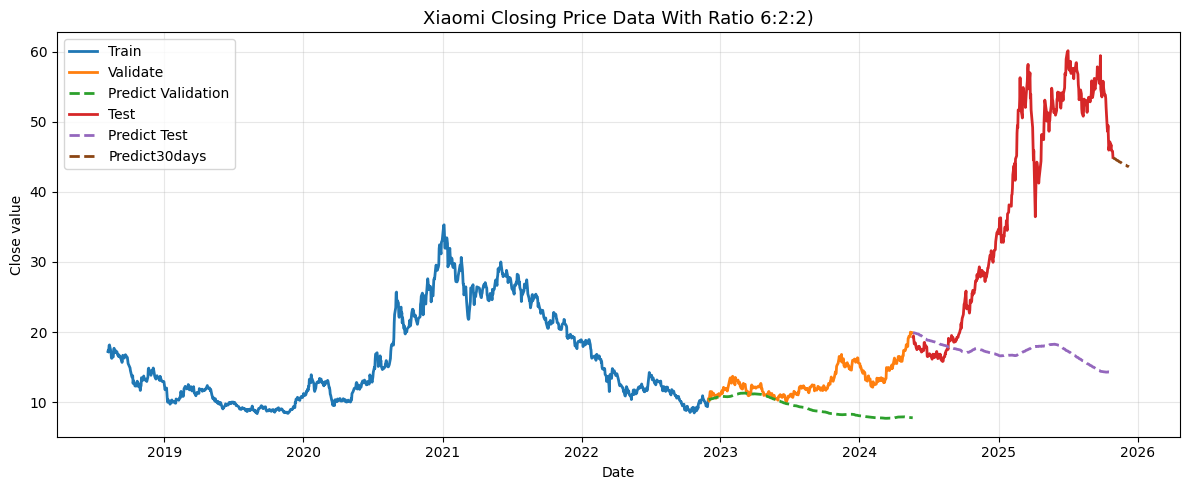

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df_train['Date'], df_train['Close'], label='Train', color='tab:blue', linewidth=2)
plt.plot(df_val['Date'],   df_val['Close'],   label='Validate', color='tab:orange', linewidth=2)
plt.plot(df_test['Date'],  df_test['Close'],  label='Test', color='tab:red', linewidth=2)
plt.plot(df_val['Date'],  pred_val,   label='Predict Validation', color='tab:green', linewidth=2, linestyle='--')
plt.plot(df_test['Date'], pred_test,  label='Predict Test', color='tab:purple', linewidth=2, linestyle='--')
plt.plot(dates30,         pred30_prices, label='Predict30days', color='saddlebrown', linewidth=2, linestyle='--')
plt.title('Xiaomi Closing Price Data With Ratio 6:2:2)', fontsize=13)
plt.xlabel('Date'); plt.ylabel('Close value')
plt.grid(True, alpha=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 3, 2, 4, 5]  # Train, Validate, Predict Validation, Test, Predict Test, Predict30days
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left', frameon=True)
plt.tight_layout(); plt.show()